In [22]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import h5py
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [10]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Preparing the Data

## Read the Data

In [3]:
kddCupTrain = pd.read_csv('~/Datasets/32017/kddCup/kddCupTrain.csv',header=None)
print("Shape of kddCupTrain: ",kddCupTrain.shape)
print("There are any missing values: ", kddCupTrain.isnull().values.any())
print(kddCupTrain.head(3))

Shape of kddCupTrain:  (985262, 42)
There are any missing values:  False
   0    1     2   3    4      5   6   7   8   9   ...  32   33   34   35   36  \
0   0  tcp  http  SF  215  45076   0   0   0   0  ...   0  0.0  0.0  0.0  0.0   
1   0  tcp  http  SF  162   4528   0   0   0   0  ...   1  1.0  0.0  1.0  0.0   
2   0  tcp  http  SF  236   1228   0   0   0   0  ...   2  1.0  0.0  0.5  0.0   

    37   38   39   40       41  
0  0.0  0.0  0.0  0.0  normal.  
1  0.0  0.0  0.0  0.0  normal.  
2  0.0  0.0  0.0  0.0  normal.  

[3 rows x 42 columns]


In [5]:
kddCupTrain.iloc[:,-1].unique()

array(['normal.', 'ipsweep.'], dtype=object)

In [6]:
kddCupTrain.rename(columns={41:'Class'}, inplace=True)
kddCupTrain['Class'] = np.where(kddCupTrain['Class'] == 'normal.', 0, 1)

In [7]:
count_classes = pd.value_counts(kddCupTrain['Class'], sort = True)
print(count_classes)

0    972781
1     12481
Name: Class, dtype: int64


## Remove the uninformative columns

Look at summaries of numeric features.

In [11]:
print(kddCupTrain.describe(percentiles=[]))

                   0             4             5              6         7  \
count  985262.000000  9.852620e+05  9.852620e+05  985262.000000  985262.0   
mean      215.078631  1.459258e+03  3.193730e+03       0.000007       0.0   
std      1343.633640  1.097984e+05  3.401613e+04       0.002665       0.0   
min         0.000000  0.000000e+00  0.000000e+00       0.000000       0.0   
50%         0.000000  2.300000e+02  4.060000e+02       0.000000       0.0   
max     58329.000000  8.958152e+07  1.173059e+07       1.000000       0.0   

                   8              9             10             11  \
count  985262.000000  985262.000000  985262.000000  985262.000000   
mean        0.000036       0.048908       0.000097       0.710185   
std         0.015897       0.926008       0.013058       0.453677   
min         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       1.000000   
max        14.000000      77.000000       4.00

Note that some features are constant (min = max and std = 0.0). Such features are not necessary and need to be removed using


In [16]:
columnsList = [7,19]

kddCupTrain.drop(columnsList, axis=1, inplace=True)

## Transform symbolic features to "One Hot" columns


Transform character features "1", "2" and "3" into "One Hot" columns using `pandas.get_dummies()`

In [20]:
kddCupTrain = pd.get_dummies(kddCupTrain, columns=[1,2,3])

print(kddCupTrain.shape)
kddCupTrain.head()

(985262, 84)


,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,Class,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,0,215,45076,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,162,4528,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,236,1228,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,233,2032,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,239,486,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Standardize the training dataset

In [23]:
featuresList = [col for col in kddCupTrain if col != 'Class']

scaler = preprocessing.StandardScaler()
scaler.fit(kddCupTrain[featuresList]);

kddCupTrain[featuresList] = scaler.transform(kddCupTrain[featuresList])
kddCupTrain.head()

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,Class,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,-0.160072,-0.011332,1.231248,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.400307,-0.459644,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.409932,-2.305156,-2.774254,-0.312768,-0.490601,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,0,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
1,-0.160072,-0.011815,0.039225,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.343674,-0.413666,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.400319,-2.293712,0.505148,-0.312768,2.892443,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,0,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
2,-0.160072,-0.011141,-0.057788,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.400307,-0.459644,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.390706,-2.282268,0.505148,-0.312768,1.200921,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,0,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
3,-0.160072,-0.011168,-0.034152,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.343674,-0.413666,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.381093,-2.270824,0.505148,-0.312768,0.625803,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,0,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,-0.001745,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,-0.001425
4,-0.160072,-0.011114,-0.079601,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.287041,-0.367688,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.371480,-2.259

## Split the data into train and test subsets 

In [25]:
X_train_split, X_test_split = train_test_split(kddCupTrain, test_size=0.2, stratify=kddCupTrain['Class'], random_state=RANDOM_SEED)

## Detach the labels from the train and the test datasets

In [26]:
y_train = X_train_split['Class']
X_train = X_train_split.drop(['Class'], axis=1)

y_test = X_test_split['Class']
X_test = X_test_split.drop(['Class'], axis=1)
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_test.shape,', shape Y',y_test.shape)

Train: shape X (788209, 83) , shape Y (788209,)
Test: shape X (197053, 83) , shape Y (197053,)


##  Separate the "normal" instances

In [28]:
X_trainNorm = X_train[y_train == 0]
X_trainNorm_val = X_trainNorm.values # Only values, axis labels removed. This is input for the Autoencoder
X_testNorm_val = X_test[y_test == 0].values # The validation data

print(y_train.shape)
print(X_train.shape)
print(X_trainNorm_val.shape)

(788209,)
(788209, 83)
(778224, 83)


# Build the model

## Select architecture of autoencoder

TODO: add batch normalization and dropout layers

In [29]:
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 14
encoder_dim = 7

In [30]:
input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(layer1_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder2 = Dense(encoder_dim, activation="relu")(encoder1)
decoder1 = Dense(layer1_dim, activation='tanh')(encoder2)
decoder2 = Dense(input_dim, activation='linear')(decoder1)
print('input_layer: ',input_layer)
print('encoder1',encoder1)
print('encoder2',encoder2)
print('decoder1',decoder1)
print('decoder2',decoder2)

W0813 10:57:09.114079 4525598144 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 10:57:09.188301 4525598144 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 10:57:09.212261 4525598144 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



input_layer:  Tensor("input_1:0", shape=(?, 83), dtype=float32)
encoder1 Tensor("dense_1/Tanh:0", shape=(?, 14), dtype=float32)
encoder2 Tensor("dense_2/Relu:0", shape=(?, 7), dtype=float32)
decoder1 Tensor("dense_3/Tanh:0", shape=(?, 14), dtype=float32)
decoder2 Tensor("dense_4/BiasAdd:0", shape=(?, 83), dtype=float32)


In [31]:
autoencoder = Model(inputs=input_layer, outputs=decoder2)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 83)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                1176      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_4 (Dense)              (None, 83)                1245      
Total params: 2,638
Trainable params: 2,638
Non-trainable params: 0
_________________________________________________________________


## Fit the model

In [32]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0) # 'patience' number of not improving epochs
history = autoencoder.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, #tensorboard, 
                               earlystopping]).history

W0813 10:58:54.652256 4525598144 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0813 10:58:54.843796 4525598144 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0813 10:58:54.973577 4525598144 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 778224 samples, validate on 194557 samples
Epoch 1/100
778224/778224 [==============================] - 44s 56us/step - loss: 0.5335 - val_loss: 0.5087
Epoch 2/100
778224/778224 [==============================] - 54s 70us/step - loss: 0.5003 - val_loss: 0.5032
Epoch 3/100
778224/778224 [==============================] - 55s 71us/step - loss: 0.4932 - val_loss: 0.4958
Epoch 4/100
778224/778224 [==============================] - 49s 63us/step - loss: 0.4873 - val_loss: 0.4909
Epoch 5/100
778224/778224 [==============================] - 52s 67us/step - loss: 0.4839 - val_loss: 0.4900
Epoch 6/100
778224/778224 [==============================] - 61s 79us/step - loss: 0.4824 - val_loss: 0.4908


# Evaluation

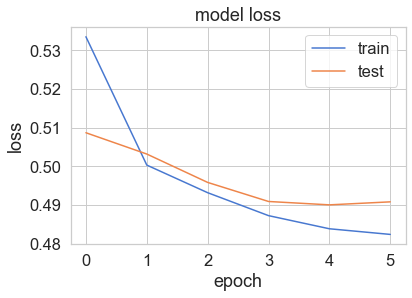

In [33]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

## Load the fitted autoencoder 

In [35]:
autoencoder = load_model('model.h5')

## Reconstruction

Reconstruct the test dataset using the fitted autoencoder, calculate the mean squared error of the prediction.

In [36]:
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape

((197053, 83), (197053, 83))

In [37]:
testMSE = mean_squared_error(X_test.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error': testMSE,'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
940543,1.296735,1
356110,0.108245,0
540178,0.004170,0
672514,0.019784,0
244980,0.004303,0


In [38]:
error_df.reconstruction_error.describe()

count    197053.000000
mean          0.598265
std          31.432826
min           0.000983
25%           0.016689
50%           0.023437
75%           0.077804
max        8622.628933
Name: reconstruction_error, dtype: float64

## Evaluate

In [40]:
from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)

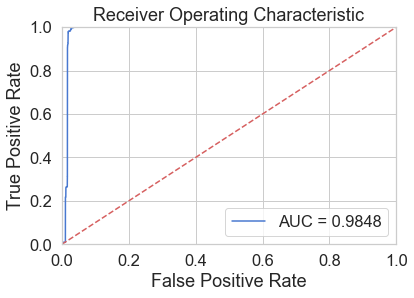

In [41]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [44]:
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
threshold = normal_error_df.reconstruction_error.quantile(q=0.995)
threshold

2.783765297278543

In [46]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

In [47]:
cohen_kappa_score(error_df.true_class, y_pred),accuracy_score(error_df.true_class, y_pred)

(0.20222957281999965, 0.9795841727860017)

# Create submission

## Read Test Data

In [77]:
kddCupTest = pd.read_csv('~/Datasets/32017/kddCup/kddCupTest.csv', header=None)
print(kddCupTest.head(3))

   0    1        2   3     4      5   6   7   8   9   10  11  12  13  14  15  \
0   0  tcp     http  SF   230  10066   0   0   0   0   0   1   0   0   0   0   
1   0  udp  private  SF   105    145   0   0   0   0   0   0   0   0   0   0   
2   1  tcp     smtp  SF  1888    374   0   0   0   0   0   1   0   0   0   0   

   16  17  18  19  20  21  22  23   24   25   26   27   28   29   30   31  \
0   0   0   0   0   0   0  19  20  0.0  0.0  0.0  0.0  1.0  0.0  0.1  255   
1   0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  255   
2   0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  255   

    32    33    34   35   36   37   38   39   40  
0  255  1.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  
1  227  0.89  0.01  0.0  0.0  0.0  0.0  0.0  0.0  
2  174  0.68  0.03  0.0  0.0  0.0  0.0  0.0  0.0  


In [78]:
print(kddCupTest.shape)
print(kddCupTest.dropna().shape)

(196557, 41)
(196557, 41)


## Do "One hot" transformation of categorical features

In [79]:
kddCupTest = pd.get_dummies(kddCupTest, columns=[1,2,3])

print(kddCupTest.shape)
kddCupTest.head()

(196557, 108)


,0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_Z39_50,2_auth,2_bgp,2_csnet_ns,2_ctf,2_daytime,2_discard,...,2_gopher,2_harvest,2_hostnames,2_http,2_http_2784,2_imap4,2_iso_tsap,2_link,2_mtp,2_name,2_netbios_dgm,2_netbios_ns,2_netbios_ssn,2_netstat,2_nntp,2_ntp_u,2_other,2_pm_dump,2_pop_2,2_pop_3,2_printer,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_sql_net,2_ssh,2_sunrpc,2_supdup,2_systat,2_telnet,2_tim_i,2_time,2_urh_i,2_urp_i,2_uucp,2_uucp_path,2_vmnet,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF
0,0,230,10066,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,19,20,0.0,0.0,0.0,0.0,1.0,0.0,0.1,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,227,0.89,0.01,0.00,0.00,0.00,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,1888,374,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,174,0.68,0.03,0.00,0.00,0.00,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,330,1477,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,9,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,94,255,1.00,0.00,0.01,0.03,0.01,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2625,146,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0.0,0.0,0.0,0.0,0.5,0.5,0.0,255,2,0.01,0.87,1.00,0.00,0.00,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Standardize the test dataset

In [89]:
pd.Series(featuresList)[~pd.Series(featuresList).isin(kddCupTest.columns)]

Series([], dtype: object)

In [84]:
kddCupTest['2_tftp_u'] = 0
kddCupTest['3_SH'] = 0

In [95]:
kddCupTest = pd.DataFrame(scaler.transform(kddCupTest[testColumnsList]))

## Make predictions and save the results to csv file

In [96]:
kddCupTest_pred = autoencoder.predict(kddCupTest)

In [97]:
kddCupTest_pred.shape

(196557, 83)

In [101]:
testMSE = mean_squared_error(kddCupTest.transpose(), kddCupTest_pred.transpose(), multioutput='raw_values')
result_df = pd.DataFrame({'reconstruction_error': testMSE}) 
result_df.to_csv('result.csv')